In [4]:
#import pandas
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")


In [5]:
import models.common as py_common 
import models.read_data as py_read_data

# 1. DATA

## 1.1. Read Data

In [6]:
sismos, all_months = py_read_data.read_data_common('./data/')
features_regression, label_regression = py_read_data.read_data_regression('./data/')

In [7]:
#get data
original_data = pd.read_csv('./data/1979_200kmSantiago.csv')
original_data['time'] = pd.to_datetime(original_data['time']) #.astype('datetime64[ns]')
original_data['date'] = pd.to_datetime([d.date() for d in original_data['time']])
original_data['hour'] = [d.time() for d in original_data['time']]

#view top 3 records
original_data.head(3)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,date,hour
0,2019-05-27 15:25:24.989000+00:00,-33.0339,-72.0603,16.84,4.4,mwr,NaN,137.0,0.355,0.69,...,earthquake,4.2,1.7,0.037,69.0,reviewed,us,us,2019-05-27,15:25:24.989000
1,2019-05-23 00:59:25.420000+00:00,-34.7971,-71.8098,48.09,4.1,mwr,NaN,83.0,0.722,0.56,...,earthquake,2.4,9.8,0.043,51.0,reviewed,us,us,2019-05-23,00:59:25.420000
2,2019-05-18 02:52:25.970000+00:00,-33.3110,-70.3431,98.23,4.2,mwr,NaN,77.0,0.045,0.31,...,earthquake,5.0,4.3,NaN,NaN,reviewed,us,guc,2019-05-18,02:52:25.970000


In [8]:
original_data.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'date', 'hour'],
      dtype='object')

## 1.2. Select columns

The Richter magnitude scale can only be used when seismographs are within 600 km of the earthquake. For greater distances, other magnitude scales have been defined. While not exactly the same as the original Richter magnitude, they give values that can range from less than 0.0 to over 9.0. For example, the surface wave magnitude, MS, is often used for large distant earthquakes. Most of these scales saturate at some magnitude and do not properly represent earthquake size for larger events. For example, the ML scale saturates over ML 6.0, while the MS scale can be used to about MS 8.0.

The most modern scale is the moment magnitude scale MW, which can be used for a wide range of magnitudes and distances. This has been defined so that the numerical value is close to ML for earthquakes up to magnitude 6.0, and close to MS for magnitudes 6.0 to 8.0. The very largest earthquakes, such as experienced in Chile in 1960 or Alaska in 1964, can reach magnitudes larger than MW 9.0.

So, for this exercise we don't take into account 'magType' and we assume all magnitude to be the same type.

In [9]:
sismos = original_data[['id', 'date', 'latitude', 'longitude', 'depth', 'mag', 'place','time']].sort_values(by=['date'])

In [10]:
sismos.head()

,id,date,latitude,longitude,depth,mag,place,time
18521,usp0000z70,1979-03-07,-32.699,-71.942,29.0,4.9,"offshore Valparaiso, Chile",1979-03-07 22:57:09.600000+00:00
18520,usp0000zk2,1979-03-22,-31.796,-69.867,117.0,4.7,"San Juan, Argentina",1979-03-22 06:51:10.600000+00:00
18519,usp0000zv5,1979-04-06,-33.148,-72.401,33.0,4.1,"offshore Valparaiso, Chile",1979-04-06 11:29:08.800000+00:00
18518,usp000109s,1979-04-26,-33.821,-71.901,38.0,5.8,"offshore Valparaiso, Chile",1979-04-26 02:00:09.600000+00:00
18516,usp00011r2,1979-07-06,-32.484,-71.584,44.0,4.8,"offshore Valparaiso, Chile",1979-07-06 11:36:32.800000+00:00


In [11]:
sismos.describe()

,latitude,longitude,depth,mag
count,18522.000000,18522.000000,18522.000000,18522.000000
mean,-33.245880,-71.081183,51.188379,3.505518
std,0.882855,0.836668,41.817346,0.653193
min,-35.231000,-72.793000,0.000000,2.500000
25%,-33.951000,-71.783000,14.900000,3.000000
50%,-33.144000,-71.173000,35.000000,3.500000
75%,-32.524250,-70.352000,88.800000,3.900000
max,-31.639000,-68.504000,226.100000,8.000000


## 1.3. Check null values

In [12]:
sismos.isnull().sum(axis = 0)

id           0
date         0
latitude     0
longitude    0
depth        0
mag          0
place        0
time         0
dtype: int64

In [13]:
sismos.isnull().values.any()

False

## 1.4. Duplicates

There is no duplicates by id

In [14]:
sismos[sismos['id'].duplicated()]

,id,date,latitude,longitude,depth,mag,place,time


In [15]:
sismos[sismos[['date', 'latitude', 'longitude']].duplicated()]

,id,date,latitude,longitude,depth,mag,place,time
11974,usp00094cx,1999-03-12,-33.158,-70.271,5.8,3.4,"Region Metropolitana, Chile",1999-03-12 16:28:22+00:00
7456,usp000bstj,2003-03-16,-33.616,-70.595,25.2,2.9,"Region Metropolitana, Chile",2003-03-16 17:28:18+00:00


In [16]:
sismos.loc[[11974,11975,11976,11972,11973]]

,id,date,latitude,longitude,depth,mag,place,time
11974,usp00094cx,1999-03-12,-33.158,-70.271,5.8,3.4,"Region Metropolitana, Chile",1999-03-12 16:28:22+00:00
11975,usp00094bv,1999-03-12,-33.158,-70.271,111.8,2.6,"Region Metropolitana, Chile",1999-03-12 05:50:04.590000+00:00
11976,usp00094bk,1999-03-12,-33.397,-70.041,127.8,2.9,"Region Metropolitana, Chile",1999-03-12 02:55:58.760000+00:00
11972,usp00094dy,1999-03-13,-33.413,-70.212,9.4,3.1,"Region Metropolitana, Chile",1999-03-13 02:55:28.320000+00:00
11973,usp00094dw,1999-03-13,-33.664,-71.410,44.8,3.7,"Valparaiso, Chile",1999-03-13 02:32:01.230000+00:00


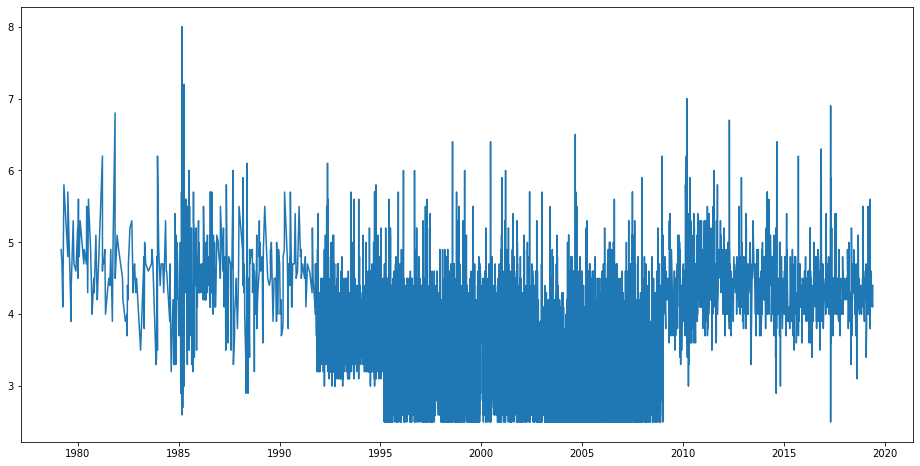

In [17]:
plt.figure(figsize=(16, 8))
plt.plot(sismos['date'],sismos['mag'])
plt.show();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f1cb198>,
      dtype=object)

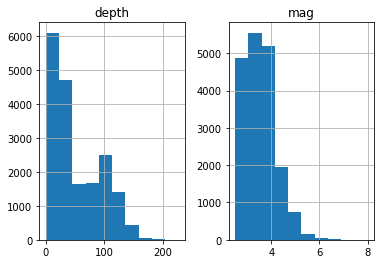

In [18]:
sismos.hist(['depth','mag'])

## 1.5 New features

In [19]:
sismos['year'] = pd.DatetimeIndex(sismos['date']).year
sismos['month'] = pd.DatetimeIndex(sismos['date']).month

sismos['YM'] =  pd.to_datetime(sismos['year'].astype(str) + '-' + sismos['month'].astype(str))
#ts['YM'] = ts['YM'].apply(lambda x : '{0:%Y-%m}'.format(x))

In [20]:
custom_magnitudes = ([0. , 4. , 6 , 10. ])
sismos['magtype'] = pd.cut(sismos['mag'], custom_magnitudes, labels=["low", "medium", "high"])

In [21]:
sismos['distcity'] = sismos['place'][sismos['place'].str.contains('km')].astype(str).str[:3]
sismos['distcity'] = sismos['distcity'].fillna(0)
sismos['distcity'] = sismos['distcity'].map(lambda x: str(x).rstrip('km'))

In [22]:
test = sismos['place'].str.split(",", n = 1, expand = True)
test2 = test[0].str.split("of", n = 1, expand = True)
test2[1] = test2[1].fillna(test2[0])
sismos['city'] = test2[1]
sismos['city'] = sismos['city'].map(lambda x: x.replace('fshore ', '').strip(' '))

In [23]:
sismos['city'].unique()

array(['Valparaiso', 'San Juan', 'Coquimbo', 'Mendoza',
       "Libertador O'Higgins", 'Maule', 'Region Metropolitana',
       "Libertador General Bernardo O'Higgins",
       'f the coast of Valparaiso', 'La Ligua', 'Los Andes', 'Santa Cruz',
       'San Antonio', 'Melipilla', 'Villa Presidente Frei', 'San Felipe',
       'Penaflor', 'Rengo', 'Hacienda La Calera', 'Curico', 'Puente Alto',
       'San Martin', 'Villa Alemana', 'Molina', 'Calingasta',
       'Vina del Mar', 'Cartagena', 'Salamanca', 'Quillota', 'Teno',
       'Illapel', 'San Vicente', 'Chimbarongo', 'El Monte', 'Machali',
       'Lo Prado', 'Quilpue', 'Paine', 'Graneros', 'Lampa', 'Malargue',
       'Rancagua'], dtype=object)

In [24]:
santiago = ["Libertador O'Higgins", "Region Metropolitana", "Libertador General Bernardo O'Higgins",
           'Villa Presidente Frei', 'Puente Alto', 'Lo Prado']
sismos['city'][sismos['city'].isin(santiago)] = 'Santiago'

In [25]:
sismos['city'][sismos['city']=='f the coast of Valparaiso'] = 'Valparaiso'

In [26]:
sismos.head(2)

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,distcity,city
18521,usp0000z70,1979-03-07,-32.699,-71.942,29.0,4.9,"offshore Valparaiso, Chile",1979-03-07 22:57:09.600000+00:00,1979,3,1979-03-01,medium,0,Valparaiso
18520,usp0000zk2,1979-03-22,-31.796,-69.867,117.0,4.7,"San Juan, Argentina",1979-03-22 06:51:10.600000+00:00,1979,3,1979-03-01,medium,0,San Juan


In [27]:
sismos.dtypes

id                        object
date              datetime64[ns]
latitude                 float64
longitude                float64
depth                    float64
mag                      float64
place                     object
time         datetime64[ns, UTC]
year                       int64
month                      int64
YM                datetime64[ns]
magtype                 category
distcity                  object
city                      object
dtype: object

## 1.6. DataFrames used below 

In [28]:
frequency_year = (sismos[['year','magtype','mag']]
                    .groupby(['year', 'magtype']) 
                    .agg(['count','max'])
                    .unstack(fill_value=0).stack()
                    .reset_index()
                    .sort_index() 
)
frequency_year.columns = [''.join(x) for x in frequency_year.columns.ravel()]
frequency_year.head(6)

,year,magtype,magcount,magmax
0,1979,low,1,3.9
1,1979,medium,11,5.8
2,1979,high,0,0.0
3,1980,low,1,4.0
4,1980,medium,20,5.6
5,1980,high,0,0.0


In [26]:
dfTiSe = (sismos[['YM','mag']]
          .groupby(['YM']).max()
          .sort_index())
dfTiSe.head(2)

,mag
YM,
1979-03-01,4.9
1979-04-01,5.8


In [27]:
allmonths = pd.DataFrame()
allmonths['YM'] = pd.date_range(start='1/1/1979', end='6/1/2019', freq='MS')
allmonths.head(2)

,YM
0,1979-01-01
1,1979-02-01


In [28]:
mag_ym = (allmonths.merge(dfTiSe, left_on='YM', right_index=True, how='left')
                   .fillna(dfTiSe['mag'].mean())
                   .set_index(allmonths['YM'])
                   .sort_index())

del mag_ym["YM"]
mag_ym.head(3)

,mag
YM,
1979-01-01,4.937365
1979-02-01,4.937365
1979-03-01,4.900000


# 2. ANALYSIS

## 2.1. frequency per year 

In [3]:
frequency_year.columns

NameError: name 'frequency_year' is not defined

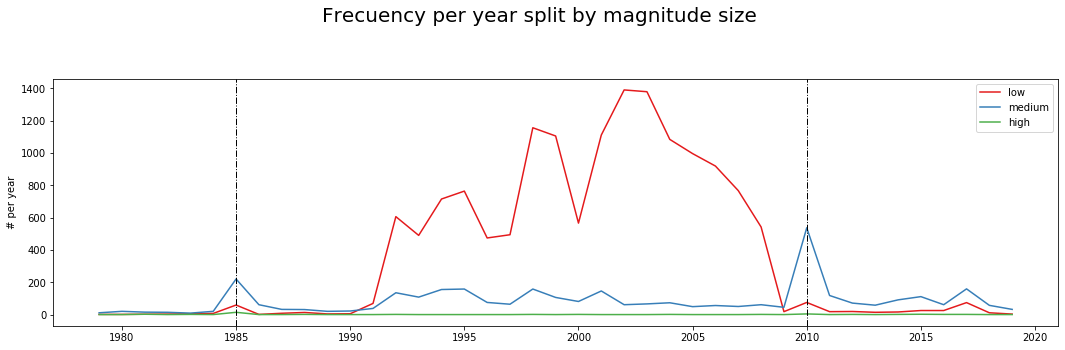

In [38]:
Common.plot_data_with_big_earthquakes('Frecuency per year split by magnitude size', '# per year',
                                     'year',frequency_year,'magcount','magtype',sismos)

## 2.2 Time Series
https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/

Time Series is a series of data points measured at a constant interval which may be hourly, daily, weekly and so on. What makes time series different is that each data point in the series is dependent on the previous data points.

__BOX-JENKINS METHODOLOGY - SUMMARY__
1.  Plot Series
    * If variance is not constant (multiplicative model) $\rightarrow$ take logarithm to make it additive
2.  Stationary 
    * Differentiate 
    * Decompose and take random part
3.  Check it is stationary with Augmented Dickey-Fuller test
4.  Plot ACF and PACF to obtain p, q in ARMA(p,q)
5.  Select the most adequate model
6.  Forecast

### 1. Plot Series

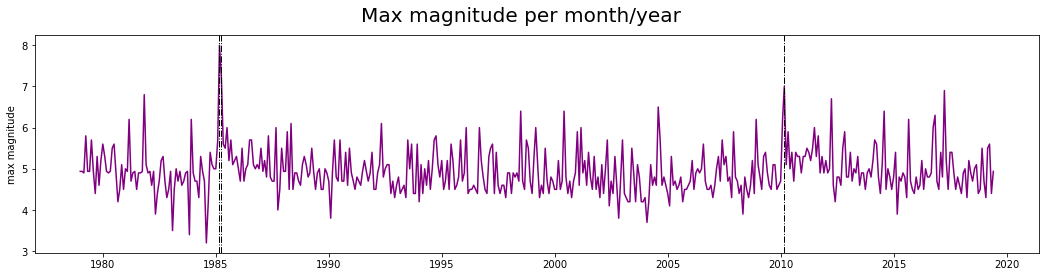

In [30]:
fig = plt.figure(figsize=(18,4)) 
ax = fig.add_subplot(111) 
ax.plot(mag_ym['mag'], color='purple', label=magtype)
plt.suptitle('Max magnitude per month/year', fontsize=20)
ax.set(ylabel='max magnitude')

#ax.xaxis.set_major_locator(dates.YearLocator(),rotation=30 )
#plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# one bar per greatest earthquakes
ym_great = dfTiSe[dfTiSe['mag']>=7].index
for ym in ym_great:
    plt.axvline(x=ym, color ="black", ls='-.', lw=1 )

plt.show;

#### Rolling Statistics

In [31]:
#Determining rolling statistics
window_size = 24
# MEAN
rolmean = mag_ym.rolling(window = window_size, center=True).mean()
# STANDAR VARIATION
rolstd = mag_ym.rolling(window = window_size, center=True).std()

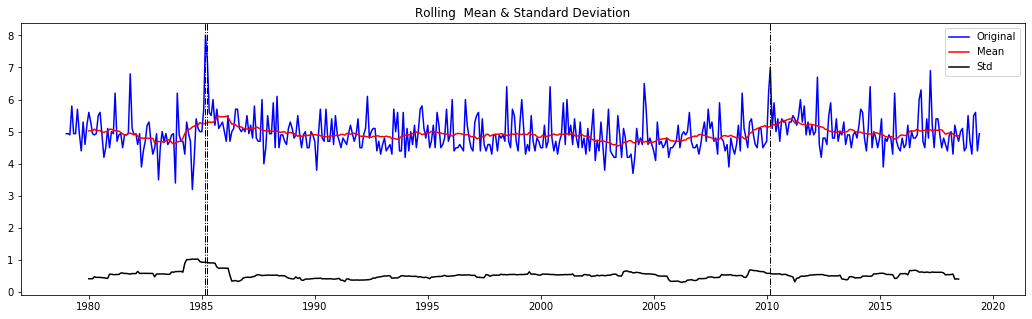

In [32]:
#plotting rolling statistics
plt.figure(figsize=(18,5))
plt.title('Rolling  Mean & Standard Deviation')
orig = plt.plot(mag_ym, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Mean')
st = plt.plot(rolstd, color = 'black', label = 'Std')
plt.legend(loc = 'best')

# one bar per greatest earthquakes
ym_great = dfTiSe[dfTiSe['mag']>=7].index
for ym in ym_great:
    plt.axvline(x=ym, color ="black", ls='-.', lw=1 )

plt.show;

Constant mean and standard variance, so Series is additive and stationary.

### 2. Stationary

How Does a Stationary Series look like?
* Constant Average
* Constant Variance
* Autocovariance does not depend on the time

How does a Non Stationary Series look like?
* Trend
* Seansonality

If it had not been stationary, we would have had to differentiate it as follows

```python
mag_diff = diff(mag_ym,k_diff=1)
```

#### Decompose

In [33]:
to_decompose = mag_ym

In [34]:
decomposition = seasonal_decompose(to_decompose)
trend = decomposition.trend.fillna(0)
seasonal = decomposition.seasonal.fillna(0)
residual = decomposition.resid.fillna(0)

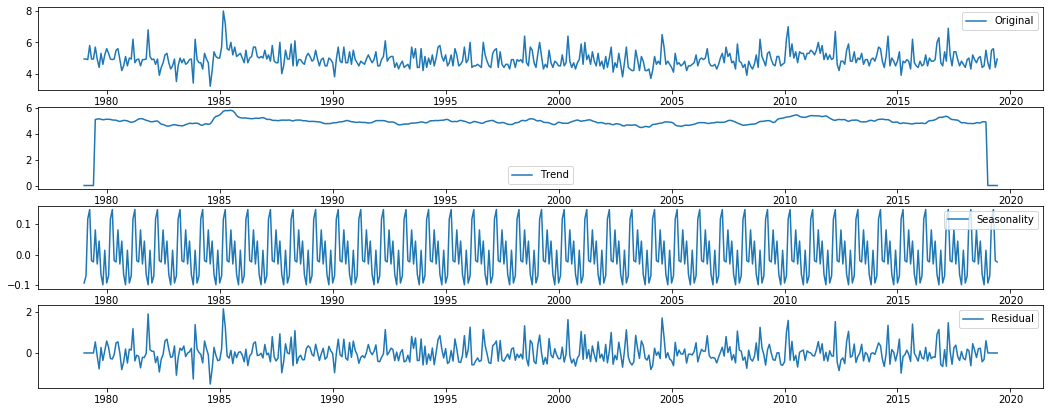

In [35]:
plt.figure(figsize=(18,7))
plt.subplot(411)
plt.plot(to_decompose, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')
plt.show;

* There is no trend
* Seasonality per year
* Additive model

### 3. Dickey Fuller Test

`Null Hypothesis`: TS has a unit root and hence is non-stationary.
    
`Test Statistic`: The more negative, the more likely we are to reject the null hypothesis (we have a stationary dataset).

We reject the null (so it is stationary) if (p-value) is small

In [35]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Dickey-Fuller Test: {title} \n')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [36]:
adf_test(residual['mag'],title='Magnitude per year')

Dickey-Fuller Test: Magnitude per year 

ADF test statistic     -1.033563e+01
p-value                 2.768708e-18
# lags used             1.800000e+01
# observations          4.670000e+02
critical value (1%)    -3.444431e+00
critical value (5%)    -2.867749e+00
critical value (10%)   -2.570077e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### 4. ACF / PACF
https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

__ACF (AutoCorrelation Function)__: 
It measures the relation between Xt and Xt+n, including Xj for j=t+1,... t+n

For __MA(q)__: Xt = εt + b1εt-1 + b2εt-2 + ... + bqεt-q , __ACF(k)__ will be 0, k>q  $\rightarrow$  see at what lag it goes down to 0

For our dataset q could be 0 or 1

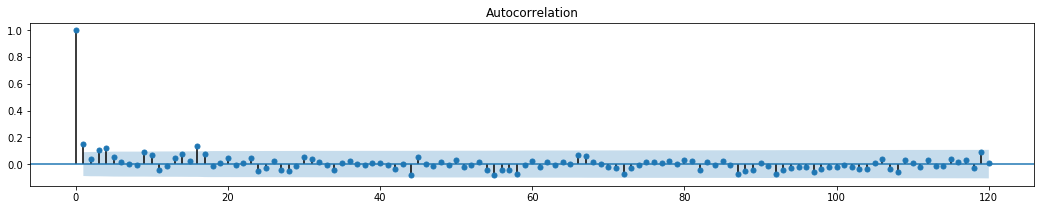

In [37]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(18,3))
    plot_acf(mag_ym, lags = 120)
    plt.show();

__PACF (Partial Autocorrelation Function)__: measures the direct relation between Xt and Xt+n, excluding Xj for j=t+1,..., t+n-1

For __AR(p)__: Xt = a1Xt-1 + a2Xt-2 + ... + apXt-p + εt. __PACF(k)__ will be high for k=1,..., p, but will be 0 afterwards (by definition) $\rightarrow$ see at what lag it goes down to 0

For our dataset q could be 1 or 16

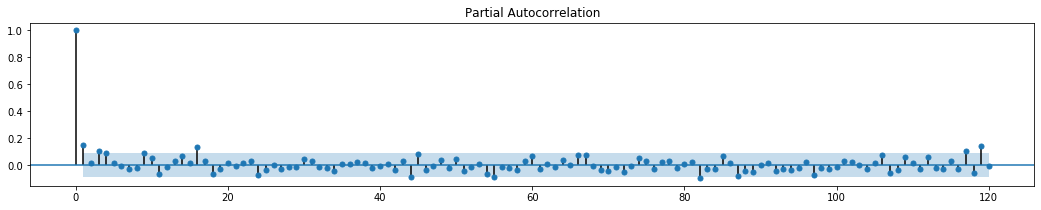

In [38]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(18,3))
    plot_pacf(mag_ym, lags=120)
    plt.show();

### 5. Most Adequate Model

! pip install pmdarima

__auto_arima__ returns best ARIMA model according to either AIC, AICc or BIC value. 

The function conducts a search over possible model within the order constraints provided.

In [39]:
from pmdarima import auto_arima
# Stationary Dataset
stepwise_fit = auto_arima(mag_ym,start_p=0,start_q=0,max_p=6,max_q=6,seasonal=False,trace=True)

Fit ARIMA: order=(0, 0, 0); AIC=806.941, BIC=815.314, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0); AIC=798.334, BIC=810.893, Fit time=0.035 seconds
Fit ARIMA: order=(0, 0, 1); AIC=798.693, BIC=811.252, Fit time=0.020 seconds
Fit ARIMA: order=(2, 0, 0); AIC=800.145, BIC=816.890, Fit time=0.027 seconds
Fit ARIMA: order=(1, 0, 1); AIC=795.757, BIC=812.502, Fit time=0.094 seconds
Fit ARIMA: order=(2, 0, 2); AIC=797.360, BIC=822.478, Fit time=0.206 seconds
Fit ARIMA: order=(2, 0, 1); AIC=796.430, BIC=817.361, Fit time=0.144 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.562 seconds


In [40]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  486
Model:                     ARMA(1, 1)   Log Likelihood                -393.878
Method:                       css-mle   S.D. of innovations              0.544
Date:                Wed, 05 Jun 2019   AIC                            795.757
Time:                        11:33:16   BIC                            812.502
Sample:                             0   HQIC                           802.335
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9378      0.039    126.670      0.000       4.861       5.014
ar.L1.y        0.8321      0.131      6.339      0.000       0.575       1.089
ma.L1.y       -0.7337      0.163     -4.490      0.000      -1.054      -0.413
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2018           +0.0000j            1.2018            0.0000
MA.1            1.3630           +0.0000j            1.3630            0.0000
-----------------------------------------------------------------------------
"""

The best model is the one with smaller AIC, that is __ARMA(1, 1)__

__AIC (Akaike Information Criterion)__ manages a trade-off between the goodness of fit of the model and the complexity of the model. 

AIC does not provide a proof of a model (there is not a null hypothesis), so it can not say anything about the quality of the model in an absolute sense. If all the candidate models fit badly, AIC will not give any notice of it.

### 6. Forecast

In [41]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(mag_ym[:50], order=(1,0,1))
model_fit = model.fit()

In [42]:
forecast_period =  pd.date_range(start='1/1/2020', end='1/1/2021', freq='MS')

In [43]:
start_month = forecast_period[0]
end_month = forecast_period[2]
forecast = model_fit.predict(start=start_month, end=end_month)

ValueError: Length of passed values is 445, index implies 3

In [ ]:
import numpy
numpy.version.version

In [ ]:
import numpy as np
import pandas as pd
X = np.random.rand(5, 2)
beta = np.random.rand(2)
s_a = pd.Series(np.ones(2))
np.matmul(X, beta * s_a)

## 2.3. LSTM with Keras

https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f
https://en.wikipedia.org/wiki/Long_short-term_memory

LSTM's are pretty good at extracting patterns, where the input data spans over long sequences. Given the gated architecture of LSTM’s that has this ability to manipulate its memory state, they are ideal for such problems.

LSTM are a special kind of Recurrent Neural Networks. 

<img src="./images/RNN.png" alt="Alt text that describes the graphic" title="RNN" style="width: 600px;"/>

This chain-like nature reveals that RNN are related to sequences. They’re the natural architecture of neural network to use for such data.

Sometimes, we only need to look at recent information to perform the present task (__Short Term__). But there are also cases where we need more context (__Long Term__). It’s entirely possible for the gap between the relevant information and the point where it is needed to become very large. Unfortunately, as that gap grows, RNNs become unable to learn to connect the information.

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<img src="./images/LSTM.png" alt="Long Short Term Memory" title="LSTM" style="width: 600px;"/>

The symbols used here have following meaning:
* X : Scaling of information
* + : Adding information
* σ : Sigmoid layer
* tanh: tanh layer
* h(t-1) : Output of last LSTM unit
* c(t-1) : Memory from last LSTM unit
* X(t) : Current input
* c(t) : New updated memory
* h(t) : Current output


https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# split into samples
X, y = split_sequence(mag_ym[:400], 20)

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(3, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

## 2.4 Prophet

## 2.5. Autocorrelation plots
Autocorrelation plots are often used for checking randomness in time series. 
* If time series is random, such autocorrelations should be near zero for any and all time-lag separations. 
* If time series is non-random then one or more of the autocorrelations will be significantly non-zero. 

The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.

As you can see below, Earthquake are random, then why so much code? easy, to learn!

https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-autocorrelation

In [ ]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(18,5))
ax1 = plt.subplot(111)
ax1.set_ylim([-0.25, 0.25])
autocorrelation_plot(mag_ym, ax1)
plt.show();

# 3. REGRESSION



## Data
https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data/data

In [371]:
temperature = pd.read_csv('./data/Temperature.csv')
temperature_chile = temperature[temperature['Country']=='Chile'][1484:]
temperature_chile['dt'] = pd.to_datetime(temperature_chile['dt'])

sismos['mag_int'] = sismos['mag'].map(lambda x: int(x))

sismos_regression = (sismos[['YM','mag_int','time']].groupby(['YM','mag_int'])
                    .agg(['count'])
                    .unstack(fill_value=0).stack()
                    .reset_index()
                    .sort_index())
sismos_regression.columns = ['YM', 'mag_int', 'count']

all_sismos_regression = (allmonths.merge(sismos_regression, left_on='YM', right_on='YM', how='left')
                                  .fillna(0))



In [413]:
# Create one column per integer magnitude, the values of these columns is the number of earthqukes of that knind in the corresponding period
features_regression = all_sismos_regression.pivot(index='YM',columns='mag_int',values='count').fillna(0).astype(object).reset_index()
del features_regression[0.0]
features_regression.columns = ('YM','2','3','4','5','6','7','8')
# Merge Esarthquake data with temperature data and select and rename columns
features_regression = features_regression.merge(temperaturas_chile, left_on='YM', right_on='dt', how='left')
features_regression = features_regression[['YM','2','3','4','5','6','7','8','AverageTemperature','AverageTemperatureUncertainty']]
features_regression.columns =  ('YM','2','3','4','5','6','7','8','Tempt','TemptUncert')
# I haven't found data for all years, so I decide set the missing values woth the values of the 10 previous years
features_regression["Tempt"][416:] = features_regression["Tempt"][344:414] 
features_regression["TemptUncert"][416:] = features_regression["TemptUncert"][344:414] 

In [430]:
""" What we want to predict it's if the next month will be a big earthquake depending on
    earthquake during current month and temperature."""
label_regression =  features_regression.apply(lambda row: 0 if ((row['6'], row['7'], row['8']) == (0,0,0)) else 1, 
                                                             axis =1)
label_regression =  label_regression.shift(-1).fillna(34).astype(object)

In [445]:
features_regression.columns

Index(['YM', '2', '3', '4', '5', '6', '7', '8', 'Tempt', 'TemptUncert'], dtype='object')

In [344]:
label_regression[-5:]

412     0
413     0
414     0
415     0
416    34
dtype: object

## Plot

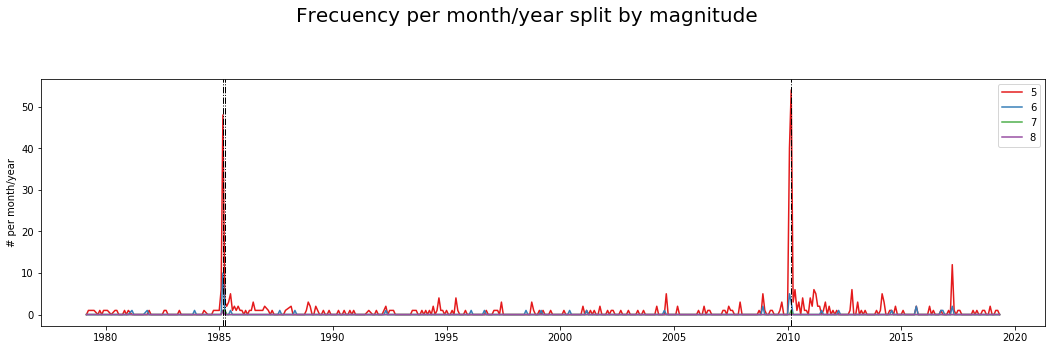

In [70]:
Common.plot_data_with_big_earthquakes('Frecuency per month/year split by magnitude', '# per month/year',
                                     'YM',sismos_regresion[sismos_regresion['mag_int']>4],'count','mag_int',sismos)

## Regression

In [55]:
param_grid = {'n_neighbors': np.arange(3)}

In [56]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [61]:
reg_test = GridSearchCV(KNeighborsRegressor(),
                        param_grid=param_grid)

In [62]:
reg_test.fit(features_regression,labels_regresion)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
reg_test.best_score_
reg_test.best_estimator_
reg_test.best_params_

# Si da tiempo

## Granger causality Test